<h1 align="center">Slay the Charts like Yoncé</h1>
<h2 align="center"><i>Why do certain songs become popular?</i></h2>
<h3 align="center">An iPython Process notebook by Crimson Dance (Julie Chang &#39;16, Steven Lee &#39;16, (Lisa) Tianxing Ma &#39;16)</h3>

<img align = "center" src="http://static.celebuzz.com/uploads/2013/09/03/beyonce-33.gif" style="width:50%;"> 

Using data from Echo Nest on song and artist characteristics, we try to determine whether we can predict a song's popularity, measured by the success on Billboard.

# Table of Contents
<ul style="list-style-type:none">
  <li><a href='#motivation'>Overview and Motivation</a></li>
  <li><a href='#related'>Related Work</a></li>
  <li><a href='#initial'>Initial Questions</a></li>
  <li><a href='#eda'>Exploratory Data Analysis</a></li>
      <ul style="list-style-type:none">
      <li><a href='#method'>Methodology</a></li>
      <li><a href='#data'>Getting the Data</a></li>
          <ul style="list-style-type:none">
              <li><a href='#year'>Billboard Yearly</a></li>
              <li><a href='#weed'>Billboard Weekly</a></li>
              <li><a href='#echonest'>Echo Nest API</a></li>
                  <ul style="list-style-type:none">
                      <li><a href='#except'>Problems with Obtaining Information for Certain Songs</a></li>
                      <li><a href='#transform'>Transforming into a Dataframe</a></li>
                      <li><a href='#newvar'>Editing and Adding New Variables</a></li>
                      <li><a href='#dup'>Managing Duplicates</a></li>
                      <li><a href='#merge'>Merge Problems</a></li>
                  </ul>
          </ul>
      <li><a href='#vis'>Visualizing the Data</a></li>
      </ul>
  <li><a href='#analysis'>Final Analysis</a></li>
  <li><a href='#pres'>Presentation</a></li>
</ul>

<a id='motivation'></a>
# Overview and Motivation
 Provide an overview of the project goals and the motivation for it. Consider that this will be read by people who did not see your project proposal.

<a id='related'></a>
# Related Work
Anything that inspired you, such as a paper, a web site, or something we discussed in class.

<a id='eda'></a>
# Exploratory Data Analysis
What visualizations did you use to look at your data in different ways? What are the different statistical methods you considered? Justify the decisions you made, and show any major changes to your ideas. How did you reach these conclusions?

<a id='method'></a>
## Methodology

We define whether a song becomes 'popular' or not by whether it made it onto the Billboard Top 100 Year-End Chart. We will examine all songs that appeared on any weekly 100 chart from 2000 to 2014 (as well as 2015 in a later analysis).

Data is pulled from three sources: 
1) Songs from Billboard Year-End Chart is obtained from Wikipedia; 
2) Songs from Billboard Weekly Charts are pulled from billboard.com;
3) Song characteristics are pulled from Echo Nest using an API.

In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import re
import math
import urllib2
import json
from pyquery import PyQuery as pq
from bs4 import BeautifulSoup
import requests
from datetime import date, timedelta

<a id='data'></a>
## Getting the Data

<a id='year'></a>
### Yearly Billboard Data

In [ ]:
# Initially we had wanted to do 20 years

years = range(1995, 2015, 1)
all_links = []

for index in range(len(years)):
    link = requests.get('http://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_ %(year)4d' % \
        {"year": years[index]}) 
    all_links.append(link)
    time.sleep(1)
    
yearstext = dict(zip(years, all_links))

In [ ]:
# Parsing the data

def cleaner(r):
    url = []
    songurl = []
    band_singer = []
    song_name = []
    songs = r[1].findAll("a")
    singers = r[2].findAll("a")
    for song in songs:
        songurl.append(song["href"])
        song_name.append(song.get_text())
    for singer in singers:
        url.append(singer["href"])
        band_singer.append(singer.get_text())
    return [int(r[0].get_text()), r[1].get_text(), band_singer, url, 
            song_name, songurl]
    
fields = ["ranking", "titletext", "band_singer", "url", "song", "songurl"]

def parse_year(year, ytextdixt):
    page_info = ytextdixt.get(year)
    parsed = BeautifulSoup(page_info.text, "html.parser")
    rows = parsed.find("table", attrs={"class": "wikitable"}).find_all("tr")[1:]
    songs = [dict(zip(fields, cleaner(row.find_all("th") + row.find_all("td")))) for row in rows]
    return songs

In [ ]:
yearinfo = {y:parse_year(y, yearstext) for y in years}

In [ ]:
# fd = open("tempdata/yearinfo.json","w")
# json.dump(yearinfo, fd)
# fd.close()

In [ ]:
# del yearinfo
with open("tempdata/yearinfo.json", "r") as fd:
    yearinfo = json.load(fd)

In [ ]:
# Transforming the json file

yeardict={}
for y in yearinfo.keys():
    yearlist=yearinfo[y]
    yearlist2=[]
    for idict in yearlist:
        singers=idict['band_singer']
        for i,s in enumerate(singers):
            songs=idict['song']
            for j,so in enumerate(songs):
                nd={}
                nd['band_singer']=s
                nd['url']=idict['url'][i]
                nd['song']=so
                nd['songurl']=idict['songurl'][j]
                nd['ranking']=idict['ranking']
                yearlist2.append(nd)
    yeardict[y]=pd.DataFrame(yearlist2)
yearspanel=pd.Panel.from_dict(yeardict, orient="minor")
hierframe=yearspanel.to_frame()

In [ ]:
flatframe = hierframe.reset_index()
flatframe.head()

In [ ]:
flatframe = flatframe.rename(columns={'minor':'year'})
del flatframe['major']
flatframe.head()

In [ ]:
flatframe.sort(["year", "ranking"], inplace=True)
flatframe.head()

In [ ]:
flatframe.to_csv("tempdata/billboard100.csv", encoding='utf-8')

In [ ]:
flatframe["year"] = flatframe["year"].astype(int)

In [ ]:
y00_14 = flatframe[(flatframe.year >= 2000) & (flatframe.year <= 2014)]

<a id='week'></a>
### Weekly Billboard Data

In [ ]:
# Define a function allsats that get saturdays in specified range

def allsats(syear, years, fs):
    days=[]
    d = date(syear, 1, fs)
    while d.year in years:
        days.append(d.strftime("%Y-%m-%d"))
        d += timedelta(days = 7)
    return days

We first get all the Saturdays from  2000 to 2014.

In [ ]:
years = [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]
sats = allsats(2000, years, 1)

Now, we get all Saturdays from 2015.

In [ ]:
years2015 = [2015]
sats2015 = allsats(2015, years2015, 1)

In [ ]:
satdict={}
satdict2015={}
for sat in sats:
    satdict[sat]=requests.get("http://www.billboard.com/charts/hot-100/"+sat).text
    time.sleep(1)
for sat in sats2015:
    satdict2015[sat]=requests.get("http://www.billboard.com/charts/hot-100/"+sat).text
    time.sleep(1)

In [ ]:
# Function to scrape information from Billboard.com

def rank_scrape(articlerows):
    songdicts = []
    songdict = {}
    ranking = 1
    for article in articlerows:
        songdict["ranking"] = ranking
        title = article.find("div", attrs={"class": "row-title"}).find("h2").get_text()
        artist = article.find("div", attrs={"class": "row-title"}).find("h3").get_text()
        title = title.strip()
        sep1 = 'Featuring'
        sep2 = ','
        sep3 = '&'
        artist = artist.split(sep1, 1)[0]
        artist = artist.split(sep2, 2)[0]
        artist = artist.split(sep3, 3)[0]
        artist = artist.strip()
        songdict["title"] = title
        songdict["artist"] = artist
        songdicts.append(dict(songdict))
        ranking += 1
    return songdicts

# Function to get information from Billboard.com for each week

def get_weekly(weekstring, indict):
    raw_chart = indict[weekstring]
    text = BeautifulSoup(raw_chart, "html.parser")
    rows = text.find_all("article", attrs={"class": "chart-row"})
    
    testdicts = rank_scrape(rows)
    for test in testdicts:
        test['date'] = weekstring
    return testdicts

Get Billboard data for 2000 to 2014

In [ ]:
weekinfo=[]
for k in sats:
    weekinfo.append(get_weekly(k, satdict))
datum = []
for week in weekinfo:
    datum.append(pd.DataFrame(week))
data2014 = pd.concat(datum, ignore_index=True)

Get Billboard data for 2015

In [ ]:
weekinfo2015=[]
for k in sats2015:
    weekinfo.append(get_weekly(k, satdict2015))
datum2015=[]
for week in weekinfo:
    datum.append(pd.DataFrame(week))
data2015 = pd.concat(datum, ignore_index=True)

#### Cleaning

In [2]:
newdata2014 = data2014.drop_duplicates(subset=['artist', 'title'])
newdata2015 = data2015.drop_duplicates(subset=['artist', 'title'])

Echo Nest API takes a long time to call, so we split the 2000-2014 dataset to make two separate calls to the API.

In [ ]:
lisa2014 = newdata2014[0:2888]
steven2014 = newdata2014[2888:]
lisa2014.to_csv('tempdata/lisa2014.csv')
steven2014.to_csv('tempdata/steven2014.csv')

<a id='echonest'></a>
### Echo Nest Data

In [ ]:
# Function get_songs
# requests and saves data on every (artist, song) combination

def get_songs(billboard):
    all_songs = []
    featurings = []
    # before when we were only pulling Billboard Year-End Hot 100
    # billboard = flatframe[(flatframe.year >= year_start) & (flatframe.year <= year_end)]
    for index, row in billboard.iterrows():
        song = urllib2.quote(row["song"].encode("utf-8"))
        artist = urllib2.quote(row["band_singer"].encode("utf-8"))
        link = requests.get('http://developer.echonest.com/api/v4/song/search?api_key=GT3HIFAMRWWCOWIAZ' + 
                            '&bucket=artist_discovery&bucket=artist_discovery_rank&bucket=artist_familiarity' +
                            '&bucket=artist_familiarity_rank&bucket=artist_hotttnesss&bucket=artist_hotttnesss_rank' +
                            '&bucket=artist_location&bucket=song_currency&bucket=song_currency_rank' +
                            '&bucket=song_discovery&bucket=song_discovery_rank&bucket=song_hotttnesss'+
                            '&bucket=song_hotttnesss_rank&bucket=song_type&bucket=audio_summary' +
                            '&results=1&title=%(song)s&artist=%(artist)s' % \
                            {"song": song, "artist": artist})
        result_json = json.loads(link.text)
        if not result_json["response"]["songs"]:
            print index, song, artist
            featurings.append(index)
        all_songs.append(result_json)
        time.sleep(3)
    return all_songs, featurings

## before we were only pulling Billboard Year-End Hot 100, our only problem was featurings:
## echonest does not seem to account for featurings, see below:
## https://developer.echonest.com/forums/thread/2007

In [ ]:
# Variables we want to obtain from Echo Nest

columns = ["title", "id", "artist_name", "artist_id", "audio_summary", "artist_discovery",
           "artist_discovery_rank", "artist_familiarity", "artist_familiarity_rank",
           "artist_hotttnesss", "artist_hotttnesss_rank", "artist_location", "song_currency", 
           "song_currency_rank", "song_discovery", "song_discovery_rank", "song_hotttnesss", 
           "song_hotttnesss_rank", "song_type"]

audio_summary = ["acousticness", "analysis_url","audio_md5", "audio_md5", "danceability", "duration", "energy", "key", 
                 "liveness", "loudness","mode", "speechiness", "tempo", "time_signature", "valence"]

In [ ]:
# Function flatten
# changes the json files we obtain from the Echo Nest into a dataframe

def flatten(all_songs, billboard):
    print len(all_songs), len(billboard) ## should be equal
    songdicts=[]
    fails = []
    total_feature_fails=0
    
    for a, i in zip(all_songs, range(len(all_songs))):
        d={}
        if a["response"]["status"]["message"] == "Success":

            if  not a["response"]["songs"]:
                total_feature_fails=total_feature_fails+1
            for b in a["response"]["songs"]:
                for var in set(b.keys()).intersection(columns):
                    if var == "audio_summary":
                        for v in set(b[var].keys()).intersection(audio_summary):
                            d[v] = b[var][v]
                    d[var] = b[var]
                    d["index"] = billboard.index[i]

                songdicts.append(d)  

        # if the requests failed
        else:
            fails.append(i)
            print i, a
    return pd.DataFrame(songdicts)

Ideally, we would be able to obtain the data in one go; however, the connection to the API would often be disconnected so we had to retrieve information in multiple parts.

In [ ]:
%%time
weekly0,problems0 = get_songs(lisa2014)

In [ ]:
%%time
weekly1,problems1 = get_songs(steven2014)

In [ ]:
%%time 
weekly2,problems2 = get_songs(newdata2015)

In [ ]:
fd=open("tempdata/lisa_songs.json","w")
json.dump(weekly0, fd)
fd.close()

In [ ]:
fd=open("tempdata/steven_songs.json","w")
json.dump(weekly1, fd)
fd.close()

In [ ]:
lisa_featurings = lisa2014.loc[problems0]
steven_featurings = steven2014.loc[problems1]

In [ ]:
lisa_featurings.to_csv("tempdata/lisaexceptions.csv")
steven_featurings.to_csv("tempdata/stevenexceptions.csv")

In [ ]:
all_songs = weekly0+weekly1+weekly2

In [ ]:
fd=open("tempdata/all_songs_00_15.json","w")
json.dump(all_songs, fd)
fd.close()

<a id='except'></a>
#### Issues with Finding Songs in Echo Nest Using Billboard Data

The Echo Nest API could not find a good number of songs due to errors with Billboard and Echo Nest. We manually cleaned the Billboard data to account for difference in Billboard and Echo Nest conventions. We ignored songs that Echo Nest did not contain data for. This included, by and large, songs that appeared in movies, covers done by artists, American Idol participants, High School Musical participants, etc.

In [ ]:
newdata2014['artist'][2931] = "Usher"
newdata2014['title'][3020] = "Bartender Song"
newdata2014['artist'][3067] = "Kid Rock"
newdata2014['artist'][3105] = "Kid Rock"
newdata2014['title'][3249] = "Move"
newdata2014['artist'][3209] = "Kenny Chesney"
newdata2014['artist'][3131] = "Kenny Chesney"
newdata2014['artist'][3142] = "Brad Paisley"
newdata2014['title'][3028] = "Out Here Grindin'"
newdata2014['title'][3072] = "Somethin' Special"
newdata2014['artist'][3075] = "Estelle"
newdata2014['artist'][3273] = "Soulja Boy"
newdata2014['artist'][3229] = "Soulja Boy"
newdata2014['artist'][3302] = "Soulja Boy"
newdata2014['artist'][3895] = "Soulja Boy"
newdata2014['artist'][3278] = "A.R. Rahman"
newdata2014['title'][3278] = "Jai Ho"
newdata2014['title'][3357] = "3 a.m."
newdata2014['artist'][3265] = "Coldplay"
newdata2014['title'][3230] = "Jizz in My Pants"
newdata2014['title'][3268] = "Fuck You"
newdata2014['artist'][3373] = "Fast Life Yungstaz"
newdata2014['title'][3411] = "Wetter"
newdata2014['artist'][3436] = "Keyshia Cole"
newdata2014['title'][3439] = "Fallin' For You"
newdata2014['artist'][3443] = "Demi Lovato"
newdata2014['artist'][3454] = "OneRepublic"
newdata2014['title'][3491] = "Gettin' You Home"
newdata2014['artist'][3492] = "Kenny Chesney"
newdata2014['artist'][3517] = "Jay-Z"
newdata2014['title'][3524] = "I'm Goin In"
newdata2014['artist'][3539] = "P!nk"
newdata2014['artist'][3569] = "Thirty Seconds to Mars"
newdata2014['artist'][3687] = "Jay-Z"
newdata2014['title'][3695] = "Stranded"
newdata2014['title'][3702] = "My City of Ruins"
newdata2014['artist'][3707] = "P!nk"
newdata2014['title'][3712] = "Fuck Today"
newdata2014['artist'][3746] = "Three 6 Mafia"
newdata2014['artist'][3875] = "V. V. Brown"
newdata2014['title'][3891] = "9AM in Dallas"
newdata2014['artist'][3897] = "Dirty Heads"
newdata2014['title'][3949] = "2012"
newdata2014['title'][3977] = "Forget You"
newdata2014['title'][4084] = "The Best Thing About Me is You"
newdata2014['artist'][4087] = "Jason Aldean"
newdata2014['artist'][4109] = "Michael Jackson"
newdata2014['title'][4234] = "Did It On Em"
newdata2014['artist'][4327] = "Enrique Iglesias"
newdata2014['artist'][4377] = "Brad Paisley"
newdata2014['title'][4403] = "The Man Who"
newdata2014['artist'][4449] = "Jay-Z"
newdata2014['artist'][4458] = "Jay-Z"
newdata2014['artist'][4462] = "Jay-Z"
newdata2014['artist'][4475] = "New Boyz"
newdata2014['artist'][4505] = "Chris Brown"
newdata2014['title'][4562] = "Stronger"
newdata2014['title'][4597] = "HYFR"
newdata2014['artist'][4652] = "Jay-Z"
newdata2014['title'][4679] = "4AM"
newdata2014['title'][4744] = "I Don't Really Care"
newdata2014['artist'][4845] = "Big Time Rush"
newdata2014['artist'][4863] = "Pusha T"
newdata2014['artist'][4928] = "Lovers' Eyes"
newdata2014['artist'][4901] = "Kanye West"
newdata2014['artist'][4970] = "Swedish House Mafia"
newdata2014['artist'][4972] = "Jason Aldean"
newdata2014['title'][4976] = "A Thousand Years"
newdata2014['artist'][4977] = "Christina Aguilera"
newdata2014['title'][5029] = "We Still In This Bitch"
newdata2014['artist'][5080] = "Tim McGraw"
newdata2014['title'][5092] = "Rich as Fuck"
newdata2014['artist'][5129] = "T.I./B.O.B./Kendrick Lamar"
newdata2014['title'][5139] = "Getting Over You"
newdata2014['title'][5161] = "Grandpa"
newdata2014['artist'][5228] = "Rich Gang"
newdata2014['artist'][5268] = "August Alsina"
newdata2014['title'][5268] = "I Luv this Shit"
newdata2014['artist'][5471] = "Fitz & The Tantrums"
newdata2014['artist'][5273] = "Zedd"
newdata2014['artist'][5277] = "Keith Urban"
newdata2014['title'][5339] = "Let Me Be Lonely"
newdata2014['artist'][5368] = "August Alsina"
newdata2014['title'][5368] = "I Luv this Shit"
newdata2014['title'][5506] = "We are One"
newdata2014['artist'][5507] = "K Camp"
newdata2014['title'][5532] = "Hold on"
newdata2014['artist'][5556] = "Miranda Lambert"
newdata2014['title'][5560] = "Help Falling In Love"
newdata2014['artist'][5588] = "X Ambassadors"
newdata2014['artist'][5573] = "Florida Georgia Line"
newdata2014['title'][5679] = "I Don't Fuck with You"
newdata2014['title'][5715] = "GDFR"
newdata2014['title'][5736] = "Shut Up and Dance"
newdata2014['artist'][5746] = "Nicki Minaj"
newdata2014['artist'][5762]= "Lilly Wood"
newdata2014['artist'][5771] = "White Buffalo"
newdata2014['title'][3695] = "Stranded"

In [ ]:
lisa_featurings['artist'][0] = "Missy Elliott"
lisa_featurings['title'][2] = "The Christmas Song"
lisa_featurings['artist'][3] = "Diddy"
lisa_featurings['artist'][5] = "Deborah Cox"
lisa_featurings['artist'][6] = "Chad Brock"
lisa_featurings['title'][7] = "U Know What's Up"
lisa_featurings['title'][8] = "He Cant Love U"
lisa_featurings['title'][9] = "That's The Way It Is"
lisa_featurings['title'][10] = "Don't Say You Love Me"
lisa_featurings['artist'][11] = "Destiny's Child"
lisa_featurings['title'][12] = "He Didn't Have To Be"
lisa_featurings['artist'][13] = "Snoop Dogg"
lisa_featurings['title'][13] = "G'd Up"
lisa_featurings['artist'][14] = "Deborah Cox"
lisa_featurings['title'][14] = "We Can't Be Friends"
lisa_featurings['artist'][15] = "Destiny's Child"
lisa_featurings['artist'][16] = "D'Angelo"
lisa_featurings['title'][17] = "She Thinks My Tractor's Sexy"
lisa_featurings['title'][18] = "What's My Name"
lisa_featurings['artist'][19] = "D'Angelo"
lisa_featurings['artist'][20] = "*NSync"
lisa_featurings['title'][21] = "I Don't Wanna"
lisa_featurings['title'][22] = "Love's The Only House"
lisa_featurings['artist'][23] = "Diddy"
lisa_featurings['artist'][24] = "Hot Boy$"
lisa_featurings['artist'][25] = "Clint Black"
lisa_featurings['artist'][26] = "2Pac"
lisa_featurings['title'][26] = "Baby Don't Cry"
lisa_featurings['title'][27] = "That's What I'm Looking For"
lisa_featurings['title'][28] = "U Don't Love Me"
lisa_featurings['title'][29] = "Daddy Won't Sell The Farm"
lisa_featurings['artist'][30] = "Kenny Rogers"
lisa_featurings['title'][31] = "She's More"
lisa_featurings['title'][32] = "He Wasn't Man Enough"
lisa_featurings['title'][33] = "Couldn't Last A Moment"
lisa_featurings['title'][34] = "Can't Stay"
lisa_featurings['title'][35] = "If You Don't Wanna Love Me"
lisa_featurings['title'][36] = "I'm Outta Love"
lisa_featurings['title'][37] = "I Don't Wanna Kiss You Goodnight"
lisa_featurings['title'][38] = "It's So Hard"
lisa_featurings['title'][39] = "Let's Get Married"
lisa_featurings['title'][40] = "It's Gonna Be Me"
lisa_featurings['title'][41] = "Jumpin', Jumpin'"
lisa_featurings['artist'][41] = "Destiny's Child"
lisa_featurings['artist'][42] = "Lee Ann Womack"
lisa_featurings['title'][43] = "I'll Be"
lisa_featurings['title'][44] = "You'll Always Be Loved By Me"
lisa_featurings['title'][45] = "Doesn't Really Matter"
lisa_featurings['title'][46] = "That's The Way"
lisa_featurings['artist'][48] = "*NSync"
lisa_featurings['artist'][49] = "*NSync"
lisa_featurings['artist'][50] = "Snoop Dogg"
lisa_featurings['title'][51] = "I Think I'm In Love With You"
lisa_featurings['title'][52] = "Ruff Ryders"
lisa_featurings['title'][53] = "Don't Think I'm Not"
lisa_featurings['title'][54] = "It's My Life"
lisa_featurings['title'][55] = "It's Always Somethin'"
lisa_featurings['title'][56] = "Let's Make Love"
lisa_featurings['artist'][56] = "Faith Hill"
lisa_featurings['artist'][57] = "P!nk"
lisa_featurings['artist'][58] = "Bow Wow"
lisa_featurings['artist'][59] = "You're A God"
lisa_featurings['artist'][60] = "Aaron's Party (Come Get It)"
lisa_featurings['artist'][61] = "Can't Fight The Moonlight"
lisa_featurings['artist'][62] = "Can't Go For That"
lisa_featurings['artist'][63] = "That's the Kind Of Mood I'm In"
lisa_featurings['title'][64] = "Indepedent Women, Part I"
lisa_featurings['artist'][64] = "Destiny's Child"
lisa_featurings['title'][65] = "You Should've Told Me"
lisa_featurings['title'][66] = "You Won't Be Lonely Now"
lisa_featurings['artist'][67] = "*NSync"
lisa_featurings['title'][68] = "What's Your Fantasy"
lisa_featurings['artist'][69] = "Cam'Ron"
lisa_featurings['title'][70] = "If You're Gone"
lisa_featurings['title'][71] = "Toca's Miracle"
lisa_featurings['title'][72] = "It Wasn't Me"
lisa_featurings['title'][73] = "No More (Baby I'ma Do Right)"
lisa_featurings['artist'][74] = "Damizza"
lisa_featurings['title'][76] = "Love Don't Cost A Thing"
lisa_featurings['title'][78] = "Don't Tell Me"
lisa_featurings['title'][79] = "It's Over Now"
lisa_featurings['artist'][80] = "*NSync"
lisa_featurings['artist'][81] = "Bow Wow"
lisa_featurings['artist'][82] = "P!nk"
lisa_featurings['artist'][83] = "Shaggy"
lisa_featurings['artist'][84] = "Ricky Martin"
lisa_featurings['artist'][85] = "Aaron Lewis"
lisa_featurings['artist'][86] = "Baha Men"
lisa_featurings['title'][87] = "Drops Of Jupiter"
lisa_featurings['artist'][88] = "Missy Elliott"
lisa_featurings['artist'][89] = "Bow Wow"
lisa_featurings['title'][90] = "Baby, Come On Over"
lisa_featurings['artist'][91] = "G. Dep"
lisa_featurings['artist'][92] = "Jagged Edge"
lisa_featurings['artist'][93] = "J. Cozier"
lisa_featurings['artist'][94] = "D12"
lisa_featurings['artist'][95] = "Missy Elliott"
lisa_featurings['artist'][96] = "Bow Wow"
lisa_featurings['title'][97] = "Livin' It Up"
lisa_featurings['artist'][98] = "*NSync"
lisa_featurings['artist'][99] = "Robert L. Huggar"
lisa_featurings['title'][100] = "Rollout (My Business)"
lisa_featurings['title'][101] = "Mamma Got Ass"
lisa_featurings['title'][102] = "Young'n"
lisa_featurings['artist'][103] = "Jo Dee Messina"
lisa_featurings['artist'][104] = "Missy Elliott"
lisa_featurings['title'][105] = "Never Too Far/Hero"
lisa_featurings['artist'][106] = "Bow Wow"
lisa_featurings['artist'][107] = "*NSync"
lisa_featurings['artist'][108] = "P!nk"
lisa_featurings['artist'][110] = "Knoc-Turn'Al"
lisa_featurings['title'][111] = "What's It Gonna Be"
lisa_featurings['artist'][112] = "Goo Goo Dolls"
lisa_featurings['title'][113] = "I'm Gonna Miss Her"
lisa_featurings['title'][114] = "Gimme The Light"
lisa_featurings['title'][115] = "I Need a Girl, Pt. 2"
lisa_featurings['artist'][115] = "Diddy"
lisa_featurings['artist'][116] = "Irv Gotti"
lisa_featurings['artist'][117] = "P!nk"
lisa_featurings['artist'][118] = "Elivs vs JXL"
lisa_featurings['title'][121] = "Out Of My Heart"
lisa_featurings['artist'][122] = "Yasmeen"
lisa_featurings['artist'][123] = "Missy Elliott"
lisa_featurings['artist'][124] = "P!nk"
lisa_featurings['artist'][125] = "Missy Elliott"
lisa_featurings['artist'][126] = "Toby Keith"
lisa_featurings['artist'][127] = "Missy Elliott"
lisa_featurings['title'][127] = "Pussycat"
lisa_featurings['title'][128] = "Never Leave You"
lisa_featurings['artist'][129] = "My a"
lisa_featurings['title'][130] = "Love @ 1st Sight"
lisa_featurings['artist'][131] = "Maroon 5"
lisa_featurings['artist'][132] = "2Pac"
lisa_featurings['artist'][133] = "M.V.P."
lisa_featurings['title'][133] = "Roc Ya Body 'Mic Check 1, 2'"
lisa_featurings['title'][134] = "Another Postcard"
lisa_featurings['artist'][135] = "2Pac"
lisa_featurings['artist'][136] = "Too $hort"
lisa_featurings['artist'][137] = "Scotty Emerick"
lisa_featurings['artist'][138] = "2Pac"
lisa_featurings['artist'][139] = "Maroon 5"
lisa_featurings['title'][140] = "Work It"
lisa_featurings['artist'][141] = "Jimmy Buffett"
lisa_featurings['artist'][143] = "Maroon 5"
lisa_featurings['title'][144] = "Shake Dat Shit"
lisa_featurings['title'][145] = "Let's Go"
lisa_featurings['artist'][146] = "Usher"
lisa_featurings['artist'][147] = "Shania Twain"
lisa_featurings['artist'][148] = "Jay-Z"
lisa_featurings['artist'][149] = "Maroon 5"
lisa_featurings['artist'][150] = "Daryl Hall"
lisa_featurings['title'][151] = "Honkytonk U"
lisa_featurings['title'][153] = "Bithces Ain't Shit"
lisa_featurings['artist'][154] = "Pretty Ricky"
lisa_featurings['artist'][155] = "The Used"
lisa_featurings['title'][156] = "Breathe (2 AM)"
lisa_featurings['title'][157] = "Trapped In The Closet Chapter 1"
lisa_featurings['artist'][158] = "Gorillaz"
lisa_featurings['title'][159] = "Helena"
lisa_featurings['artist'][161] = "Jeezy"
lisa_featurings['artist'][162] = "Damian Marley"
lisa_featurings['artist'][163] = "50 Cent"
lisa_featurings['title'][163] = "Outta Control"
lisa_featurings['title'][164] = "Heard 'Em Say"
lisa_featurings['artist'][165] = "Shakira"
lisa_featurings['title'][166] = "Kryptonite"
lisa_featurings['artist'][166] = "Cristian Castro"
lisa_featurings['artist'][167] = "Jeezy"
lisa_featurings['artist'][180] = "Angels & Airwaves"
lisa_featurings['title'][182] = "I Love My Bitch"
lisa_featurings['artist'][183] = "Mary J. Blige"
lisa_featurings['artist'][184] = "Janet"
lisa_featurings['artist'][185] = "Thirty Seconds To Mars"
lisa_featurings['artist'][186] = "Sean Paul"
lisa_featurings['title'][188] = "Love Me Or Hate Me"
lisa_featurings['artist'][191] = "Thirty Seconds To Mars"
lisa_featurings['title'][192] = "b.u.d.d.y."
lisa_featurings['artist'][193] = "Nake Brothers Band"
lisa_featurings['artist'][194] = "Bow Wow"
lisa_featurings['title'][196] = "Pop Lock & Drop It"
lisa_featurings['artist'][197] = "P!nk"
lisa_featurings['artist'][198] = "Maroon 5"
lisa_featurings['artist'][202] = "Down"
lisa_featurings['artist'][203] = "R. Kelly"
lisa_featurings['title'][204] = "Do You Know? (The Ping Pong Song)"
lisa_featurings['artist'][205] = "Tim McGraw"
lisa_featurings['artist'][228] = "Soulja Boy"
lisa_featurings['artist'][229] = "Billy Ray Cyrus"
lisa_featurings['artist'][236] = "Michael Jackson"
lisa_featurings['artist'][237] = "Soulja Boy"

We make API calls once more with this updated data. We have done this process in another notebook and we are reading in the information here.

In [ ]:
with open("tempdata/julie_fixes.json") as json_file:
    steven2014_add = json.load(json_file)

In [ ]:
fixed1=pd.read_csv("./tempdata/juliefixessteven2014.csv")
# fixed1.head()

In [ ]:
with open("tempdata/steven_fixes.json") as json_file:
    lisa2014_add = json.load(json_file)

In [ ]:
fixed0=pd.read_csv("./tempdata/stevenfixeslisa2014.csv")
# fixed1.head()

<a id='transform'></a>
#### Transforming Echo Nest data into a Dataframe

In [ ]:
df0 = flatten(weekly0, lisa2014)
# df0.head()

In [ ]:
df0_with_date=pd.merge(df0, lisa2014[["date", "ranking"]], left_on=["index"], right_index=True)
df0_with_date.rename(columns={'ranking':'first_ranking'}, inplace=True)
df0_with_date.head()

In [ ]:
df1 = flatten(weekly1, steven2014)
# df1.head()

In [ ]:
df1_with_date=pd.merge(df1, steven2014[["date", "ranking"]], left_on=["index"], right_index=True)
df1_with_date.rename(columns={'ranking':'first_ranking'}, inplace=True)
df1_with_date.head()

In [ ]:
df2015 = flatten(board2015, billboard2015)
# df2015.head()

In [ ]:
df2015_with_date=pd.merge(df2015, billboard2015[["date", "ranking"]], left_on=["index"], right_index=True)
df2015_with_date.rename(columns={'ranking':'first_ranking'}, inplace=True)
df2015_with_date.head()

In [ ]:
df0_fixes = flatten(board0_add, fixed0)

In [ ]:
df0_fixes_with_date=pd.merge(df0_fixes, fixed0[["date", "ranking"]], left_on=["index"], right_index=True)
df0_fixes_with_date.rename(columns={'ranking':'first_ranking'}, inplace=True)
df0_fixes_with_date.head()

In [ ]:
df1_fixes = flatten(board1_add, fixed1)

In [ ]:
df1_fixes_with_date=pd.merge(df1_fixes, fixed1[["date", "ranking"]], left_on=["index"], right_index=True)
df1_fixes_with_date.rename(columns={'ranking':'first_ranking'}, inplace=True)
df1_fixes_with_date.head()

In [ ]:
frames = [df0_with_date, df0_fixes_with_date, df1_with_date, df1_fixes_with_date, df2015_with_date,]
df = pd.concat(frames)

<a id='newvar'></a>
#### Editing and Adding New Variables
The Billboard year starts at the first week of December to the last week of November, hence we create new variables to account for this difference from the regular year. We also parse location information while we do this process.

In [ ]:
no_weeks = [52, 52, 52, 52, 53, 52, 52, 52, 52, 53, 52, 52, 52, 52, 52, 53]
years = range(2000,2016)
no_wks = dict(zip(years, no_weeks))

In [ ]:
df["billboard_year"] = np.nan
df["billboard_week"] = np.nan
df["latitude"] = np.nan
df["longitude"] = np.nan
df["location"] = ""
df["location_lower"] = ""
maps = {(0,0): "Trial"}

for index, row in df.iterrows():
    year = int(row.date[:4])
    month = int(row.date[5:7])
    day =  int(row.date[8:10])
    today = datetime.date(year, month, day)
    weeks = no_wks[year]
    add = 5
    if (month == 12) & ((today.weekday()-today.day>=-1)):
        add = weeks - today.isocalendar()[1] + 1
        df.ix[index, "billboard_year"] = year+1
        df.ix[index, "billboard_week"] = 1
    elif ((today.isocalendar()[1] + add)%(weeks)==0):
        df.ix[index, "billboard_year"] = year
        df.ix[index, "billboard_week"] = weeks
    else:
        df.ix[index, "billboard_year"] = year
        df.ix[index, "billboard_week"] = (today.isocalendar()[1] + add)%(weeks)
    
    locate = row["artist_location"]
    if locate:
        if locate["latitude"]:
            df.ix[index, "latitude"] = locate["latitude"]
        if locate["longitude"]:
            df.ix[index, "longitude"] = locate["longitude"]
        if locate["location"]:
            if (locate["latitude"]==True) & (locate["longitude"]==True):
                coords = (locate["latitude"], locate["longitude"])
#                 print coords
                if coords in maps:
                    df.ix[index, "location"] = maps[coords]
                    df.ix[index, "location_lower"] = maps[coords].lower()
                else:
                    maps[coords] = locate["location"]
                    df.ix[index, "location"] = locate["location"]
                    df.ix[index, "location_lower"] = locate["location"].lower() 
            else:
                df.ix[index, "location"] = locate["location"]
                df.ix[index, "location_lower"] = locate["location"].lower() 

In [ ]:
df["billboard_week"].describe() ## should range from 1 to 53

In [ ]:
df.head()

<a id='dup'></a>
#### Deleting Duplicate Rows
We only want unique combinations of song title and artist in each billboard year.

In [ ]:
ids = df[["title", "artist_name", "billboard_year"]]

In [ ]:
duplicated=ids[ids.duplicated()]
len(duplicated)

In [ ]:
len(df[df.title.isin(duplicated.title) & df.artist_name.isin(duplicated.artist_name) 
       & df.billboard_year.isin(duplicated.billboard_year)].sort("title"))

In [ ]:
df_unique = df.drop(duplicated.index)

In [ ]:
ids2 = df_unique[["title", "artist_name", "billboard_year"]]
len(ids2[ids2.duplicated()]) ## should now be 0

<a id='merge'></a>
#### Merging Echo Nest data with Billboard Year-End Hot 100 singles data

We turn song title and artist names to all lowercase to have more successful merges.

In [ ]:
df_unique.loc[:,"lower_title"] = df_unique["title"].str.lower()
df_unique.loc[:,"lower_artist"] = df_unique["artist_name"].str.lower()

In [ ]:
y00_14.loc[:,"lower_title"] = y00_14["song"].str.lower()
y00_14.loc[:,"lower_artist"] = y00_14["band_singer"].str.lower()

In [ ]:
df_all = pd.merge(df_unique, y00_14, how='left', on=["lower_title", "lower_artist"], suffixes=('_x', '_y'))

In [ ]:
df_all.ranking.describe()

In [ ]:
## number of songs with no ranking
df_all.ranking.isnull().sum()

In [ ]:
## songs from Billboard Year-End Hot 100 that did not merge with Echo Nest data
missing_ranks = y00_14[(~y00_14.lower_title.isin(df_all.lower_title))&(~y00_14.lower_artist.isin(df_all.lower_artist))].sort("band_singer")
missing_ranks.head()

In [ ]:
lisa_featurings.head()

In [ ]:
steven_featurings.head()

In [ ]:
## songs that not receive data from Echo Nest
frames2 = [lisa_featurings, steven_featurings]
need = pd.concat(frames2)

In [ ]:
need.loc[:,"lower_title"] = need["title"].str.lower()
need.loc[:,"lower_artist"] = need["artist"].str.lower()

In [ ]:
## figure out where the problems are
probs = []
for index, row in missing_ranks.iterrows():
    found = need[(need["lower_title"] == row.lower_title)&(need["lower_artist"] == row.lower_artist)]
    if len(found):
        print found, "in exceptions"
    else:
        probs.append(index)    

In [ ]:
missing_ranks.loc[probs]

In [ ]:
## Echo Nest dataset with no ranking
no_ranking = df_all[df_all.ranking.isnull()]

Manually find discrepancies in how songs and/or artists were written on Wikipedia vs. on Echo Nest.

In [ ]:
# no_ranking[no_ranking.title.str.contains("I Need a Girl")]

In [ ]:
df_all.loc[702, ["year", "band_singer", "ranking", "song", "songurl", "url"]] = missing_ranks.loc[367]

In [ ]:
# no_ranking[no_ranking.title.str.contains("Next")]

In [ ]:
df_all.loc[4702, ["year", "band_singer", "ranking", "song", "songurl", "url"]] = missing_ranks.loc[2484]

In [ ]:
# no_ranking[no_ranking.title.str.contains("Problems")]

In [ ]:
df_all.loc[4583, ["year", "band_singer", "ranking", "song", "songurl", "url"]] = missing_ranks.loc[1238]

In [ ]:
# df_all[["year", "band_singer", "ranking", "song", "songurl", "url"]].loc[4583]

In [ ]:
# no_ranking[no_ranking.title.str.contains("All The Small Things")]

In [ ]:
df_all.loc[47, ["year", "band_singer", "ranking", "song", "songurl", "url"]] = missing_ranks.loc[885]

In [ ]:
# df_all[["year", "band_singer", "ranking", "song", "songurl", "url"]].loc[47]

In [ ]:
# no_ranking[no_ranking.title.str.contains("Your Heart")]

In [ ]:
df_all.loc[1674, ["year", "band_singer", "ranking", "song", "songurl", "url"]] = missing_ranks.loc[1050]

In [ ]:
# df_all[["year", "band_singer", "ranking", "song", "songurl", "url"]].loc[1674]

In [ ]:
## new Echo Nest dataset with no ranking
no_ranking2 = df_all[df_all.ranking.isnull()]

In [ ]:
len(no_ranking), len(no_ranking2)

In [ ]:
df_all.head()

In [ ]:
df_all.to_csv("tempdata/df_all_cleaned5.csv", encoding='utf-8')

In [ ]:
df_all_00_14 = df_all[df_all.billboard_year!=2015]

In [ ]:
df_all_15 = df_all[df_all.billboard_year==2015]

In [ ]:
df_all_00_14.to_csv("tempdata/df_all_00_14.csv", encoding='utf-8')

In [ ]:
df_all_15.to_csv("tempdata/df_all_15.csv", encoding='utf-8')

<a id='vis'></a>
## Visualizing the Data

# TODO

In [4]:
# read in the data UPDATE!!!!!!!!!
finaldata=pd.read_csv("./tempdata/df_all_cleaned4.csv")
finaldata.head()

,Unnamed: 0,acousticness,analysis_url,artist_discovery,artist_discovery_rank,artist_familiarity,artist_familiarity_rank,artist_hotttnesss,artist_hotttnesss_rank,artist_id,artist_location,artist_name,audio_md5,audio_summary,danceability,duration,energy,id,index,key,liveness,loudness,mode,song_currency,song_currency_rank,song_discovery,song_discovery_rank,song_hotttnesss,song_hotttnesss_rank,song_type,speechiness,tempo,time_signature,title,valence,date,first_ranking,lower_title,lower_artist,year,band_singer,ranking,song,songurl,url,billboard_year,billboard_week,latitude,longitude,location,location_lower
0,0,0.023664,http://echonest-analysis.s3.amazonaws.com/TR/P...,0.369704,NaN,0.673539,NaN,0.588086,NaN,ARN7POH1187B9B301E,"{u'latitude': 32.576489, u'location': u'Abilen...",Jessica Simpson,510d03f7f7773ffe84bd6365e75dfc45,"{u'key': 4, u'analysis_url': u'http://echonest...",0.644058,232.59955,0.872039,SOZYMAL14B5D7A5698,2,4,0.033556,-9.151,0,0.006367,NaN,0.000000,NaN,0.355779,NaN,"[studio, electric, vocal]",0.044870,130.180,4,I Wanna Love You Forever,0.626382,2000-01-01,3,i wanna love you forever,jessica simpson,2000,Jessica Simpson,56,I Wanna Love You Forever,/wiki/I_Wanna_Love_You_Forever,/wiki/Jessica_Simpson,2000,5,32.576489,-99.665323,"Abilene, TX","abilene, tx"
1,1,0.046606,http://echonest-analysis.s3.amazonaws.com/TR/7...,0.299033,437039,0.811461,83,0.654229,1358,AR30R5E1187B9AD78A,"{u'latitude': 40.736101, u'location': u'Newark...",Whitney Houston,24aa3d1259e3480900721571bc4fe8d6,"{u'key': 0, u'analysis_url': u'http://echonest...",0.660295,258.09288,0.847010,SOPBEQQ12B0B80B9BD,3,0,0.066933,-6.398,1,0.028660,24931,0.002068,1561470,0.461754,9856,"[studio, electric, vocal]",0.037339,134.980,4,My Love Is Your Love,0.510183,2000-01-01,4,my love is your love,whitney houston,2000,Whitney Houston,47,My Love Is Your Love,/wiki/My_Love_Is_Your_Love_(song),/wiki/Whitney_Houston,2000,5,40.736101,-74.225090,"Newark, NJ","newark, nj"
2,2,0.240021,http://echonest-analysis.s3.amazonaws.com/TR/r...,0.453046,30544,0.561868,5061,0.596687,2763,AR6JVK31187FB58FE3,"{u'latitude': 45.05, u'location': u'Turin, Ita...",Eiffel 65,NaN,"{u'key': 7, u'analysis_url': u'http://echonest...",0.812507,210.18667,0.971241,SOOAIRU146168415C1,12,7,0.386530,-6.810,0,0.055708,11236,0.006311,567371,0.471915,8139,"[studio, electric, vocal]",0.052639,127.982,4,Blue (Da Ba Dee),0.795222,2000-01-01,13,blue (da ba dee),eiffel 65,2000,Eiffel 65,49,Blue (Da Ba Dee),/wiki/Blue_(Da_Ba_Dee),/wiki/Eiffel_65,2000,5,45.050000,7.666667,"Turin, Italy","turin, italy"
3,3,0.161116,http://echonest-analysis.s3.amazonaws.com/TR/O...,0.416272,NaN,0.542365,NaN,0.532190,NaN,ARM8DAD1187B993E2E,"{u'latitude': 26.0657, u'location': u'Davie, F...",Guy,a533657e04f50cb451677695ce32c756,"{u'key': 1, u'analysis_url': u'http://echonest...",0.833038,281.56757,0.337699,SOQSRPK13E90787CD5,18,1,0.185389,-16.155,1,0.000000,NaN,0.000000,NaN,0.000000,NaN,"[studio, electric, vocal]",0.151720,101.108,4,Dancin',0.705580,2000-01-01,19,dancin',guy,NaN,NaN,NaN,NaN,NaN,NaN,2000,5,26.065700,-80.234900,"Davie, FL, US","davie, fl, us"
4,4,0.562595,http://echonest-analysis.s3.amazonaws.com/TR/j...,0.487270,5662,0.417185,31892,0.521144,11716,AR8VNGZ1187FB4168D,"{u'latitude': 43.6486, u'location': u'Toronto,...",LEN,6ab709aba3e5f7f1b7bf1892307d7c89,"{u'key': 4, u'analysis_url': u'http://echonest...",0.580348,203.04934,0.680611,SOAEYTC144D7F51291,19,4,0.579321,-19.717,1,0.045766,15729,0.000000,NaN,0.508462,4178,"[studio, vocal]",0.068707,96.171,4,Steal My Sunshine,0.729627,2000-01-01,20,steal my sunshine,len,NaN,NaN,NaN,NaN,NaN,NaN,2000,5,43.648600,-79.385300,"Toronto, Ontario, CA","toronto, ontario, ca"


In [5]:
# prepare variables for observation
print list(finaldata.columns.values)

variables = ['acousticness','artist_discovery','artist_discovery_rank','artist_familiarity', 'artist_familiarity_rank',
             'artist_hotttnesss','artist_hotttnesss_rank','duration','danceability', 'energy','key','liveness','loudness','mode',
             'song_currency','song_currency_rank','song_discovery','song_discovery_rank','song_hotttnesss',
             'song_hotttnesss_rank','speechiness','tempo','time_signature','valence', 'first_ranking', 'billboard_week']

len(variables)

['Unnamed: 0', 'acousticness', 'analysis_url', 'artist_discovery', 'artist_discovery_rank', 'artist_familiarity', 'artist_familiarity_rank', 'artist_hotttnesss', 'artist_hotttnesss_rank', 'artist_id', 'artist_location', 'artist_name', 'audio_md5', 'audio_summary', 'danceability', 'duration', 'energy', 'id', 'index', 'key', 'liveness', 'loudness', 'mode', 'song_currency', 'song_currency_rank', 'song_discovery', 'song_discovery_rank', 'song_hotttnesss', 'song_hotttnesss_rank', 'song_type', 'speechiness', 'tempo', 'time_signature', 'title', 'valence', 'date', 'first_ranking', 'lower_title', 'lower_artist', 'year', 'band_singer', 'ranking', 'song', 'songurl', 'url', 'billboard_year', 'billboard_week', 'latitude', 'longitude', 'location', 'location_lower']


26

We look at how these variables may have changed over time.

/Users/StevenLee/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/Users/StevenLee/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


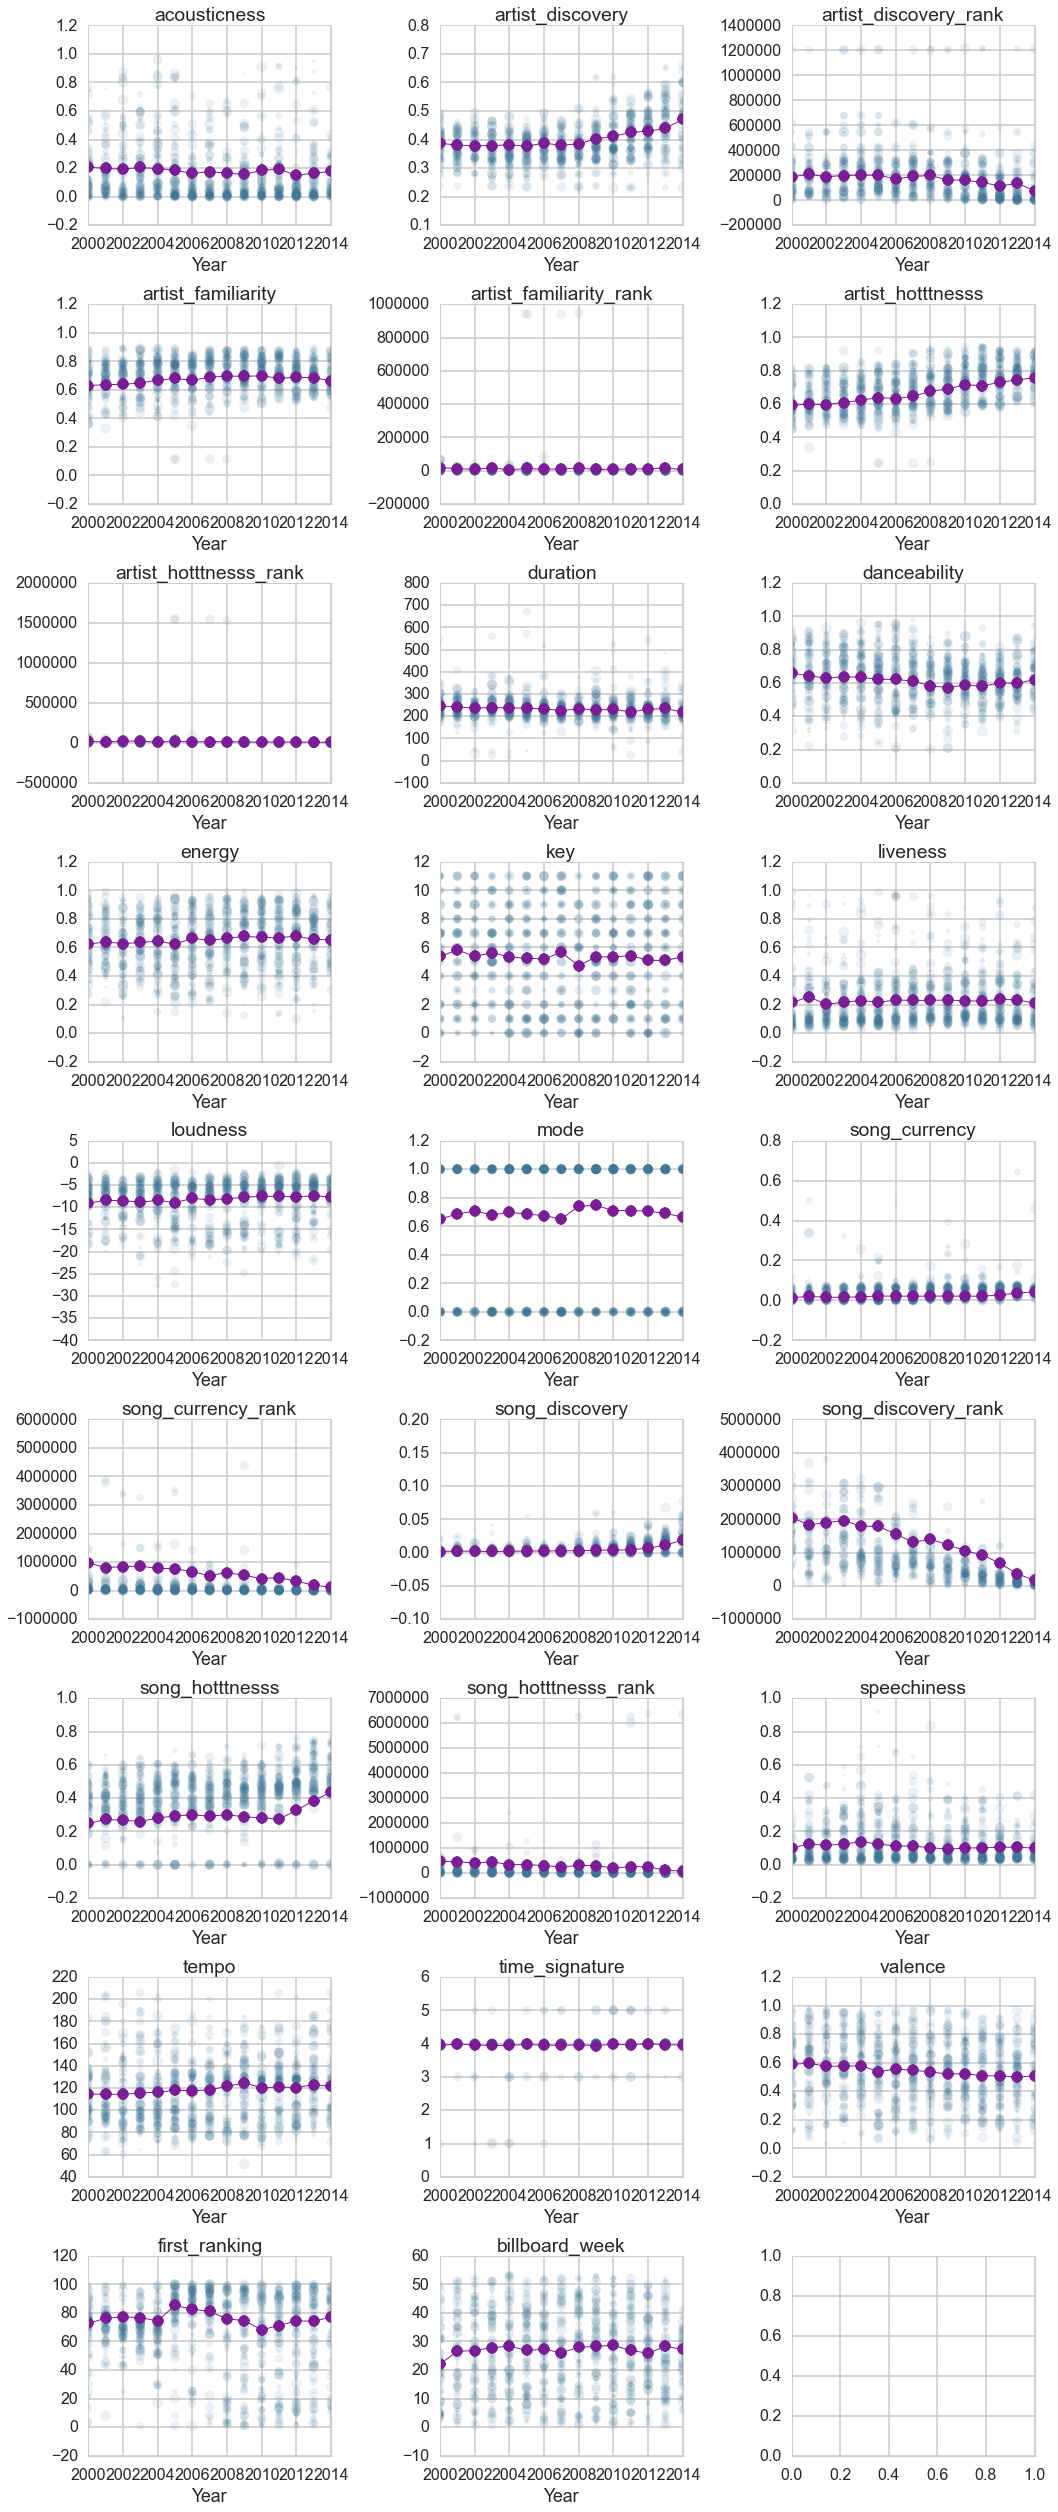

In [6]:
fig, axes = plt.subplots(nrows=9, ncols=3, figsize=(15, 35), tight_layout = True)
fig.subplots_adjust(hspace=3, wspace = 2)

for ax, var in zip(axes.ravel(), variables):
    ax.set_xlim([2000,2014])

    ax.scatter(finaldata["billboard_year"], finaldata[var],marker='o', color = "#407899", alpha=.1, s = finaldata["ranking"])

    ax.plot(finaldata["billboard_year"].unique(), finaldata.groupby("billboard_year")[var].mean(), 
            'o-', color='#791E94', lw=1, label='Decade Average')

    ax.set_title(var)

    ax.set_xlabel("Year")

<a id='analysis'></a>
# Final Analysis
What did you learn about the data? How did you answer the questions? How can you justify your answers?

<a id='pres'></a>
# Presentation
Present your final results in a compelling and engaging way using text, visualizations, images, and videos on your project web site.